In [2]:
import os
import cv2
import sys
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def relu(x):
    assert isinstance(x, np.ndarray), "ReLU: l'entrée doit être un ndarray"
    return np.maximum(0, x)

def relu_derivative(x):
    assert isinstance(x, np.ndarray), "ReLU Derivative: l'entrée doit être un ndarray"
    return (x > 0).astype(float)

def softmax(x):
    assert isinstance(x, np.ndarray), "Softmax: l'entrée doit être un ndarray"
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [4]:
class MultiClassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, lambda_reg=0.01):
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes doit être une liste avec au moins 2 couches"
        assert all(isinstance(x, int) and x > 0 for x in layer_sizes), "Toutes les tailles de couches doivent être des entiers > 0"
        assert learning_rate > 0, "Le learning rate doit être positif"
        assert 0 < beta1 < 1 and 0 < beta2 < 1, "beta1 et beta2 doivent être dans (0,1)"
        assert epsilon > 0, "epsilon doit être positif"
        assert lambda_reg >= 0, "lambda_reg doit être >= 0"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.lambda_reg = lambda_reg
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        np.random.seed(42)
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01 for i in range(len(layer_sizes)-1)]
        self.biases = [np.zeros((1, layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
        self.m_weights = [np.zeros_like(w) for w in self.weights]
        self.v_weights = [np.zeros_like(w) for w in self.weights]
        self.m_biases = [np.zeros_like(b) for b in self.biases]
        self.v_biases = [np.zeros_like(b) for b in self.biases]

    def forward(self, X):
        assert isinstance(X, np.ndarray), "Forward: X doit être un ndarray"
        assert X.shape[1] == self.layer_sizes[0], f"Dimension d'entrée attendue {self.layer_sizes[0]}, reçue {X.shape[1]}"
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights)-1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            self.z_values.append(z)
            self.activations.append(relu(z))
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        self.z_values.append(z)
        output = softmax(z)
        self.activations.append(output)
        return output

    def compute_loss(self, y_true, y_pred):
        assert y_true.shape == y_pred.shape, "y_true et y_pred doivent avoir les mêmes dimensions"
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        l2_penalty = sum(np.sum(np.square(w)) for w in self.weights)
        loss += (self.lambda_reg / (2 * y_true.shape[0])) * l2_penalty
        return loss

    def compute_accuracy(self, y_true, y_pred):
        assert y_true.shape == y_pred.shape, "y_true et y_pred doivent avoir les mêmes dimensions"
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)

    def backward(self, X, y, outputs):
        assert X.shape[0] == y.shape[0], "X et y doivent avoir le même nombre d'échantillons"
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = outputs - y
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m + (self.lambda_reg / m) * self.weights[-1]
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights)-2, -1, -1):
            dZ = (dZ @ self.weights[i+1].T) * relu_derivative(self.z_values[i])
            self.d_weights[i] = (self.activations[i].T @ dZ) / m + (self.lambda_reg / m) * self.weights[i]
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
        self.t += 1
        for i in range(len(self.weights)):
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * self.d_weights[i]
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * np.square(self.d_weights[i])
            m_hat = self.m_weights[i] / (1 - self.beta1**self.t)
            v_hat = self.v_weights[i] / (1 - self.beta2**self.t)
            self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * self.d_biases[i]
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * np.square(self.d_biases[i])
            m_hat = self.m_biases[i] / (1 - self.beta1**self.t)
            v_hat = self.v_biases[i] / (1 - self.beta2**self.t)
            self.biases[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        assert epochs > 0, "epochs doit être > 0"
        assert batch_size > 0, "batch_size doit être > 0"
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        assert isinstance(X, np.ndarray), "predict: X doit être un ndarray"
        outputs = self.forward(X)
        return np.argmax(outputs, axis=1)

    def cross_validate(self, X, y, k=5, epochs=50, batch_size=32):
        assert k > 1, "k doit être > 1"
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        fold_accuracies = []
        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            self.__init__(self.layer_sizes, self.learning_rate, self.beta1, self.beta2, self.epsilon, self.lambda_reg)
            self.train(X_train, y_train, X_val, y_val, epochs, batch_size)
            val_pred = self.predict(X_val)
            true_labels = np.argmax(y_val, axis=1)
            accuracy = np.mean(val_pred == true_labels)
            fold_accuracies.append(accuracy)
            print(f"Fold {fold+1} accuracy: {accuracy:.4f}")
        print(f"\nMean CV accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
        return fold_accuracies

In [5]:
def load_data(zip_path, extract_path):
    if not os.path.exists(extract_path):
        if os.path.exists(zip_path):
            try:
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(os.path.dirname(extract_path))
                    print(f"Extracted dataset to {extract_path}")
            except zipfile.BadZipFile:
                return None, None, None, None, None
        else:
            return None, None, None, None, None
    else:
        print(f"Dataset already exists at {extract_path}")
    data_dir = extract_path
    labels_csv_path = os.path.join(data_dir, "labels-map.csv")
    if os.path.exists(labels_csv_path):
        labels_df = pd.read_csv(labels_csv_path, names=['image_path', 'label'])
    else:
        image_paths, labels = [], []
        tifinagh_dir = os.path.join(data_dir, "tifinagh-images")
        if not os.path.exists(tifinagh_dir):
            return None, None, None, None, None
        for label_dir in os.listdir(tifinagh_dir):
            label_path = os.path.join(tifinagh_dir, label_dir)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    relative_path = os.path.join("tifinagh-images", label_dir, img_name)
                    image_paths.append(relative_path)
                    labels.append(label_dir)
        labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
    labels_df['image_path'] = labels_df['image_path'].apply(lambda x: x.replace('./images-data-64/', '') if isinstance(x, str) else x)
    label_encoder = LabelEncoder()
    labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
    num_classes = len(label_encoder.classes_)
    def load_and_preprocess_image(image_path, data_dir, target_size=(32, 32)):
        full_path = os.path.join(data_dir, image_path)
        img = cv2.imread(full_path, cv2.IMREAD_COLOR)
        assert img is not None, f"Impossible de charger l'image {full_path}"
        assert img.ndim == 3 and img.shape[2] == 3, f"L'image {full_path} n'est pas RGB"
        img = cv2.resize(img, target_size)
        return img.astype(np.float32).flatten() / 255.0
    X = np.array([load_and_preprocess_image(path, data_dir) for path in labels_df['image_path']])
    y = labels_df['label_encoded'].values
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    y_one_hot = one_hot_encoder.fit_transform(y.reshape(-1, 1))
    assert X.shape[0] == y_one_hot.shape[0], "Nombre d'échantillons X et y incohérent"
    return X, y, y_one_hot, num_classes, label_encoder

In [6]:
def main():
    zip_path = "/content/drive/MyDrive/Colab Notebooks/amhcd-data-64.zip"
    extract_path = "/content/amhcd-data-64"
    epochs = 100
    batch_size = 32
    learning_rate = 0.001
    lambda_reg = 0.01
    X, y, y_one_hot, num_classes, label_encoder = load_data(zip_path, extract_path)
    if X is None:
        print("Failed to load dataset. Exiting.")
        return
    assert X.shape[1] == 32*32*3, "Chaque image doit être aplatie en un vecteur de taille 3072 (32x32x3)"
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    random_indices = np.random.choice(len(X), size=10, replace=False)
    for i, ax in enumerate(axes.flat):
        idx = random_indices[i]
        img = X[idx].reshape(32, 32, 3)
        ax.imshow(img)
        ax.set_title(f"Label: {label_encoder.classes_[y[idx]]}")
        ax.axis('off')
    plt.suptitle("Exemples aléatoires d'images RGB")
    plt.show()
    X_temp, X_test, y_temp, y_test = train_test_split(X, y_one_hot, test_size=0.2, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
    assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Split dataset incorrect"
    layer_sizes = [X_train.shape[1], 128, 64, num_classes]
    nn = MultiClassNeuralNetwork(layer_sizes, learning_rate=learning_rate, lambda_reg=lambda_reg)
    train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train, y_train, X_val, y_val, epochs, batch_size)
    nn.cross_validate(X_train, y_train, k=5, epochs=50, batch_size=batch_size)
    y_pred = nn.predict(X_test)
    y_test_labels = np.argmax(y_test, axis=1)
    print("\nClassification Report (Test set):")
    print(classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.close()
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        idx = np.random.randint(0, len(X_test))
        img = X_test[idx].reshape(32, 32, 3)
        true_label = label_encoder.classes_[y_test_labels[idx]]
        pred_label = label_encoder.classes_[y_pred[idx]]
        ax.imshow(img)
        ax.set_title(f"Tue label:{true_label}\nPredict label:{pred_label}", color=("green" if true_label == pred_label else "red"))
        ax.axis('off')
    plt.suptitle("Exemples de prédictions sur le test set")
    plt.show()
    print("\nTraining completed. Results saved to confusion_matrix.png and training_curves.png")

Dataset already exists at /content/amhcd-data-64


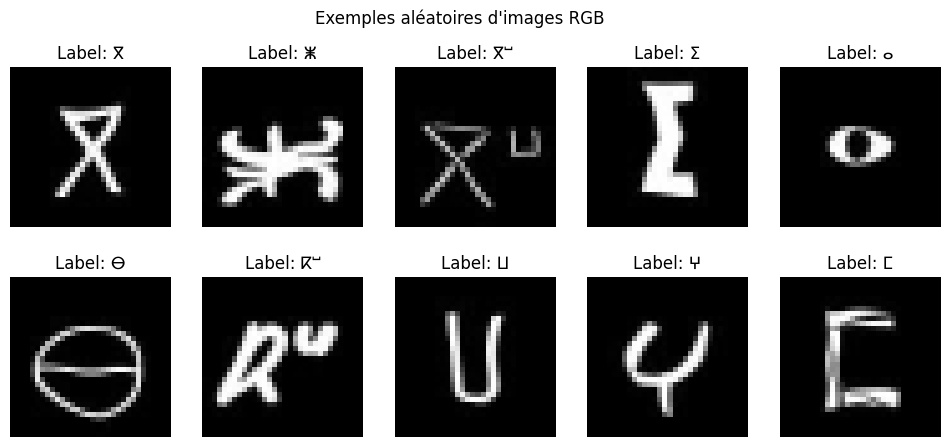

Epoch 0, Train Loss: 2.2699, Val Loss: 1.5290, Train Acc: 0.5213, Val Acc: 0.5107
Epoch 10, Train Loss: 0.3884, Val Loss: 0.3428, Train Acc: 0.9380, Val Acc: 0.8874
Epoch 20, Train Loss: 0.2574, Val Loss: 0.2620, Train Acc: 0.9723, Val Acc: 0.9172
Epoch 30, Train Loss: 0.2323, Val Loss: 0.3321, Train Acc: 0.9521, Val Acc: 0.9012
Epoch 40, Train Loss: 0.2264, Val Loss: 0.2083, Train Acc: 0.9874, Val Acc: 0.9384
Epoch 50, Train Loss: 0.2229, Val Loss: 0.2270, Train Acc: 0.9803, Val Acc: 0.9305
Epoch 60, Train Loss: 0.2254, Val Loss: 0.1791, Train Acc: 0.9912, Val Acc: 0.9407
Epoch 70, Train Loss: 0.2015, Val Loss: 0.2440, Train Acc: 0.9750, Val Acc: 0.9248
Epoch 80, Train Loss: 0.1905, Val Loss: 0.2519, Train Acc: 0.9775, Val Acc: 0.9230
Epoch 90, Train Loss: 0.1886, Val Loss: 0.1533, Train Acc: 0.9952, Val Acc: 0.9502
Epoch 0, Train Loss: 2.3801, Val Loss: 1.7390, Train Acc: 0.4735, Val Acc: 0.4583
Epoch 10, Train Loss: 0.3956, Val Loss: 0.3646, Train Acc: 0.9451, Val Acc: 0.8820
Epoch 

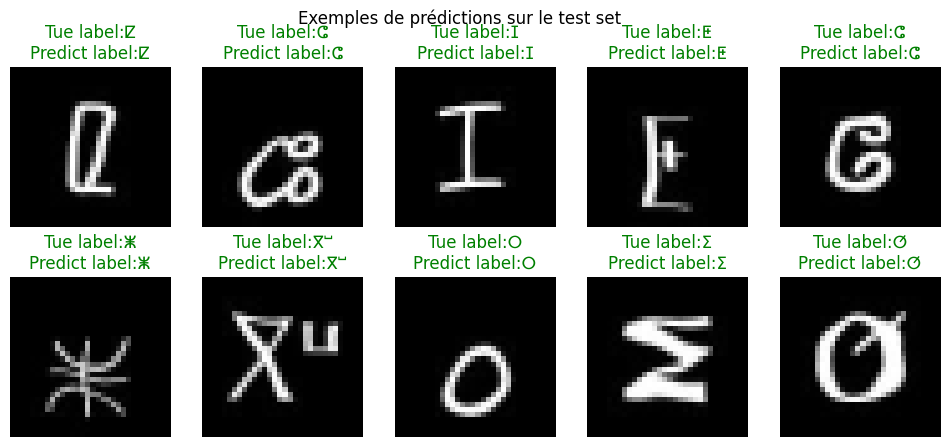


Training completed. Results saved to confusion_matrix.png and training_curves.png


In [7]:
if __name__ == "__main__":
    main()